In [1]:
import glob

import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from random import shuffle
import imutils
import os
import time
import timeit
import itertools
import dlib

from imutils import face_utils

from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Convolution3D, ZeroPadding3D, Activation, MaxPooling3D, Flatten, Dropout, BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import SGD, rmsprop, Adam
from keras.models import model_from_json
from keras.utils import to_categorical, plot_model

np.random.seed(7)
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

# add GraphViz library for keras architecure plotting, if on Windows
if os.name == 'nt':
    os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

Using TensorFlow backend.


In [2]:
# source folder of video files
source_folder = 'c:\\lrw_dataset_video'
# destination folder of frames
target_folder = 'c:\\lrw_dataset_frame'

# sizes of mouth region -> input shape
IMG_ROWS = 35
IMG_COLS = 50
VID_DEPTH = 28

In [3]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
p = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

In [4]:
 # selected subset of words for training
selected = ["AGREEMENT","BENEFIT", "EXPECTED","CUSTOMERS","CONSERVATIVE"]
print(len(selected))

5


### Data Preprocessing

In [5]:
def convert_video_to_3d_array(video):
    cap = cv2.VideoCapture(video)

    cnt = 0
   
    lipsFrames = []
        
    current_video_array = None

    while cap.isOpened():
        # Capture frame-by-frame
        ret, frame = cap.read()
        
        if ret == True:
        
            # convert frame to grayscale
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # detect faces in the grayscale image
            rects = detector(gray, 0)
        
            # loop over the face detections
            for (i, rect) in enumerate(rects):
                # determine the facial landmarks for the face region, then
                # convert the facial landmark (x, y)-coordinates to a NumPy
                # array
                global shape
                shape = predictor(gray, rect)
                shape = face_utils.shape_to_np(shape)
            
            # crop_img = frame[top:bottom, left:right]
            crop = gray[ shape[14][1]:shape[11][1], shape[6][0]:shape[10][0]]
            crop = cv2.resize(crop, (IMG_COLS,IMG_ROWS))
            #cv2.imwrite("frame"+str(count)+".jpg", crop)     # save frame as JPG file
        
            lips_resized = cv2.resize(crop, (IMG_COLS, IMG_ROWS), interpolation=cv2.INTER_AREA)
            lipsFrames.append(lips_resized)
                
                    
        # if video is empty, skip the sample
        else:
            break
        
        cnt += 1
        if cnt > VID_DEPTH:
            current_video_array = np.array(lipsFrames, dtype="uint8")
            break
            
    cap.release()
    return current_video_array

In [6]:
# cycle over words of subset(train / val / test)
def crop_frames_and_save(set_type, words):
    
    # create target_folder if it doesnt exists
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
        
    # create TYPE folder if it doest exists
    if not os.path.exists(os.path.join(target_folder, set_type)):
        os.makedirs(os.path.join(target_folder, set_type))
        
    for current_word in words:

        word_files = glob.glob(os.path.join(source_folder, current_word, set_type, '') + "*.mp4")
        saved = 0
        skipped = 0

        # cycle thru word samples
        for i, video in enumerate(word_files):
            np_frame_array = convert_video_to_3d_array(video)

            if np_frame_array is not None:
                if not os.path.exists(os.path.join(target_folder, set_type, current_word)):
                    os.makedirs(os.path.join(target_folder, set_type, current_word))
                
                np.save(os.path.join(target_folder, set_type, current_word, str(i)), np_frame_array)
                saved += 1
            else:
                skipped += 1
        
        print("Word: {}, saved/skipped: {}/{}".format(current_word, saved, skipped))

In [7]:
crop_frames_and_save("train", selected)
crop_frames_and_save("val", selected)
crop_frames_and_save("test", selected)

Word: AGREEMENT, saved/skipped: 400/0
Word: BENEFIT, saved/skipped: 400/0
Word: EXPECTED, saved/skipped: 400/0
Word: CUSTOMERS, saved/skipped: 400/0
Word: CONSERVATIVE, saved/skipped: 400/0
Word: AGREEMENT, saved/skipped: 40/0
Word: BENEFIT, saved/skipped: 40/0
Word: EXPECTED, saved/skipped: 40/0
Word: CUSTOMERS, saved/skipped: 40/0
Word: CONSERVATIVE, saved/skipped: 40/0
Word: AGREEMENT, saved/skipped: 40/0
Word: BENEFIT, saved/skipped: 40/0
Word: EXPECTED, saved/skipped: 40/0
Word: CUSTOMERS, saved/skipped: 40/0
Word: CONSERVATIVE, saved/skipped: 40/0


### Data Loading & Labels

In [8]:
nb_classes = len(selected)  # len(words)

labels = selected
labels_num = [i for i in range(0, len(labels))]
one_hot_labels = to_categorical(labels_num)

labels_num_dict = dict(zip(labels, labels_num))
labels_hot_dict = dict(zip(labels, one_hot_labels))

In [9]:
def sample_generator(basedir, set_type, batch_size):
      
    # Directory from which to load samples
    directory = os.path.join(basedir, set_type)
    
    # Placeholder NumPy arrays for features and labels
    batch_features = np.zeros((batch_size, VID_DEPTH+1, IMG_ROWS, IMG_COLS, 1))
    batch_labels = np.zeros((batch_size, nb_classes), dtype="uint8")
    
    file_list = []
    # Populate with file paths and labels
    for word_folder in labels:
        file_list.extend((word_folder, os.path.join(directory, word_folder, word_name)) \
                         for word_name in os.listdir(os.path.join(directory, word_folder)))
    
    while True:
#         seq_det = seq.to_deterministic()
        for b in range(batch_size):
            
            i = np.random.choice(len(file_list), 1)[0]
            
            sample = np.load(file_list[i][1])  # get random sample
#             sample = augment_sample(sample, seq_det)
            
            # Normalize to [-1; 1]
            sample = (sample.astype("float16") - 128) / 128 
            sample = sample.reshape(sample.shape + (1,))
    
            batch_features[b] = sample
            batch_labels[b] = labels_hot_dict[file_list[i][0]]  # get one_hot vector label

        yield (batch_features, batch_labels)

### Check Shape ofGenerated Samples

In [10]:
a = sample_generator(target_folder, "val", 2)
s = next(a)
print(s[0].dtype, s[1].dtype)
print(s[0].shape, s[1].shape)

float64 uint8
(2, 29, 35, 50, 1) (2, 5)


In [11]:
# load all data at once into array - e.g when evaluating the test subset
def get_all_data(basedir, set_type):

    directory = os.path.join(basedir, set_type)
    file_list = []
    for word_folder in labels:
        file_list.extend((word_folder, os.path.join(directory, word_folder, word_name)) \
                         for word_name in os.listdir(os.path.join(directory, word_folder)))
        
    shuffle(file_list)
    
    X = []
    y = []
    
    for f in file_list:
        
        sample = np.load(f[1])
        sample = (sample.astype("float16") - 128) / 128  # normalize to 0 - 1
        X.append(sample)
        
        y.append(labels_hot_dict[f[0]])
    
    X = np.array(X)
    X = X.reshape(X.shape + (1,))

    return (X, np.array(y))

### Train Model

In [12]:
model_name = "model"
models_dir = 'models/'

In [13]:
def get_model():  
    
   
    model = Sequential()
    model.add(Convolution3D(64, (5, 5, 5), padding='same', activation='relu', 
                            input_shape=(VID_DEPTH+1, IMG_ROWS, IMG_COLS, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(3, 3, 3)))
    model.add(Dropout(0.2))

    model.add(Convolution3D(128, (5, 5, 5), padding='same', activation='relu'))
    model.add(MaxPooling3D(pool_size=(3, 3, 3)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Convolution3D(128, (5, 5, 5), padding='same', activation='relu'))
    model.add(MaxPooling3D(pool_size=(3, 3, 3)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Convolution3D(512, (5, 5, 5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(nb_classes, activation='softmax'))
        
        
    return model

### Compile Model

In [14]:
opt = Adam(lr=1e-4)

model = get_model()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

##compile(optimizer, loss=None, metrics=None, loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Saving & Plotting Model Architecture

In [15]:
# save model architecture to json
model_json = model.to_json()
with open(models_dir + model_name + ".json", "w") as json_file:
    json_file.write(model_json)

# print / plot model architecture
model.summary()
plot_model(model, to_file='outputs/architecture_{}.pdf'.format(model_name), show_shapes=True, show_layer_names=False) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 29, 35, 50, 64)    8064      
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 35, 50, 64)    256       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 9, 11, 16, 64)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 11, 16, 64)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 9, 11, 16, 128)    1024128   
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 3, 3, 5, 128)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 3, 5, 128)      512       
__________

### Keras Callbacks Initialization

In [1]:
tensorboard = TensorBoard(log_dir="logs/{}".format(model_name),
                          write_graph=True, write_images=True)
    
filepath = models_dir + model_name + ".h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                             save_best_only=True, save_weights_only=True, mode='max')

earlyStopping = EarlyStopping(monitor='val_acc', patience=3, verbose=1, mode='max')

csv_logger = CSVLogger('outputs/log_{}.csv'.format(model_name), append=True, separator=';')

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.0001)

NameError: name 'TensorBoard' is not defined

### Run Training

In [18]:
nb_epoch = 20
batch_size = 16

num_examples = nb_classes * 400
num_val_examples = nb_classes * 40

history = model.fit_generator(
          generator=sample_generator(target_folder, "train", batch_size),
          epochs=nb_epoch,
          steps_per_epoch=num_examples // batch_size,
          validation_data=sample_generator(target_folder, "val", batch_size),
          validation_steps=num_val_examples // batch_size,
          verbose=True,
          callbacks = [tensorboard, checkpoint, earlyStopping, csv_logger] # learning_rate_reduction
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
125/125 [==============================] - 1974s 16s/step - loss: 1.8750 - acc: 0.2615 - val_loss: 1.6887 - val_acc: 0.3698

Epoch 00001: val_acc improved from -inf to 0.36979, saving model to models/model_26052019_LRW2.h5
Epoch 2/20
125/125 [==============================] - 1942s 16s/step - loss: 1.7082 - acc: 0.3240 - val_loss: 1.6629 - val_acc: 0.3646

Epoch 00002: val_acc did not improve from 0.36979
Epoch 3/20
125/125 [==============================] - 1998s 16s/step - loss: 1.5527 - acc: 0.3820 - val_loss: 1.5791 - val_acc: 0.3854

Epoch 00003: val_acc improved from 0.36979 to 0.38542, saving model to models/model_26052019_LRW2.h5
Epoch 4/20
125/125 [==============================] - 2052s 16s/step - loss: 1.2551 - acc: 0.5190 - val_loss: 1.1133 - val_acc: 0.5573

Epoch 00004: val_acc improved from 0.38542 to 0.55729, saving model to models/model_26052019_LRW2.h5
Epoch 5/20
125/125 [==============================] - 2052

### Plot Results after Training

In [19]:
def plot_and_save_training():
    plt.figure(1, figsize=(8,8))
    # summarize history for accuracy
    plt.subplot(211)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid()

    # summarize history for loss
    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid()
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    
    plt.savefig('outputs/train_{}.pdf'.format(model_name))
    plt.show()

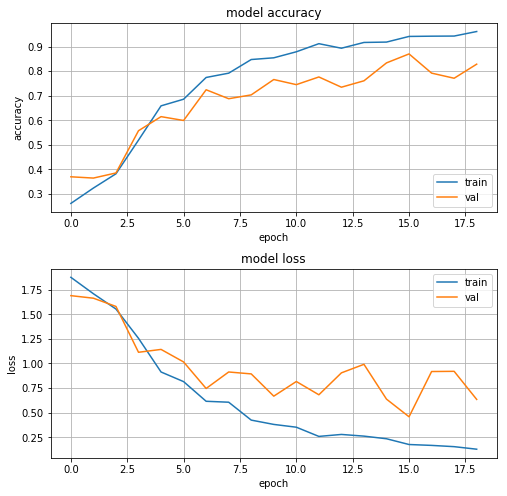

In [20]:
plot_and_save_training()

### Evaluate Model on Test Data

In [21]:
model_name = "model"
models_dir = 'models/'

In [22]:
def load_model(model_path, model_weights_path):

    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # load weights into new model
    loaded_model.load_weights(model_weights_path)
    print("Loaded Model from disk")

    # compile and evaluate loaded model
    loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    print("Loaded Model Weights from disk")

    return loaded_model

In [23]:
 model = load_model(models_dir + model_name + '.json', models_dir + model_name + '.h5')

Loaded Model from disk
Loaded Model Weights from disk


In [24]:
 X_test, y_test = get_all_data("C:\\lrw_dataset_frame\\", "test")

In [26]:
scores = model.evaluate(X_test, y_test)

print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

200/200 [==============================] - 45s 227ms/step

acc: 75.00%


In [27]:
predictions = model.predict_classes(X_test)
lab = np.argmax(y_test, axis=1)

cm = confusion_matrix(lab, predictions)

In [28]:
def plot_and_save_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    
    # Source: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(orientation="horizontal", pad=0.14, shrink=0.5)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:d}".format(int(cm[i, j] * 100)),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:d}".format(int(cm[i, j] * 100)),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', color="black")
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), color="black")
    
    plt.savefig('outputs/conf_matrix_{}.pdf'.format(model_name))
    plt.show()

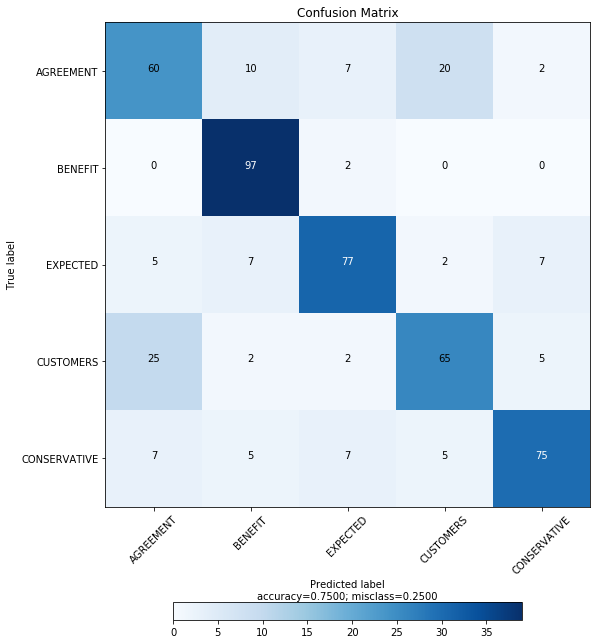

In [29]:
plot_and_save_confusion_matrix(cm, labels, title="Confusion Matrix")